<a href="https://colab.research.google.com/github/utkuarik/StyleClipManipulation/blob/master/StyleCLIP_Manipulation_Latent_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b>StyleCLIP Manipulation</b>

* This is a simple tutorial with source code for <b>[StyleCLIP](https://arxiv.org/abs/2103.17249)</b>.
* <b>Reference</b>: [Original StyleCLIP source code](https://github.com/orpatashnik/StyleCLIP)
* The project forked from https://colab.research.google.com/github/ndb796/StyleCLIP-Tutorial/blob/main/StyleCLIP_Latent_Optimization.ipynb#scrollTo=H6nZr8uSFraJ

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=c2d0eac5f8d2a3452f2ab633c4a8c2e89650483038d717c5bcaf70540279bb09
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-dqqqsq7n
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-dqqqsq7n
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369090 sha256=0bdcae862a5ade536380614fdd577751d8c08d5b1035d1ff5e81277f4c657563
  Stored in directory: /tmp/pip-ephem-wheel-cache-pf2wmj3l/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

Cloning into 'StyleCLIP-Tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 19), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.
/content/StyleCLIP-Tutorial


In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2021-10-22 13:31:28--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVnY2eXVzRXQxdEZockwzVEN1MFRhNEJscHpXM2VCTVRTMHlUUEtvZE5Ic05BP3J0aW1lPWRWb2VRV0NWMlVn [following]
--2021-10-22 13:31:29--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVnY

In [ ]:
import torch
from stylegan2.model import Generator
from scipy.spatial import distance

g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema = g_ema.cuda()

#### <b>CLIP Loss</b>

In [ ]:
import clip


class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

#### <b>Latent Optimization</b>

* The basic idea is as follows:

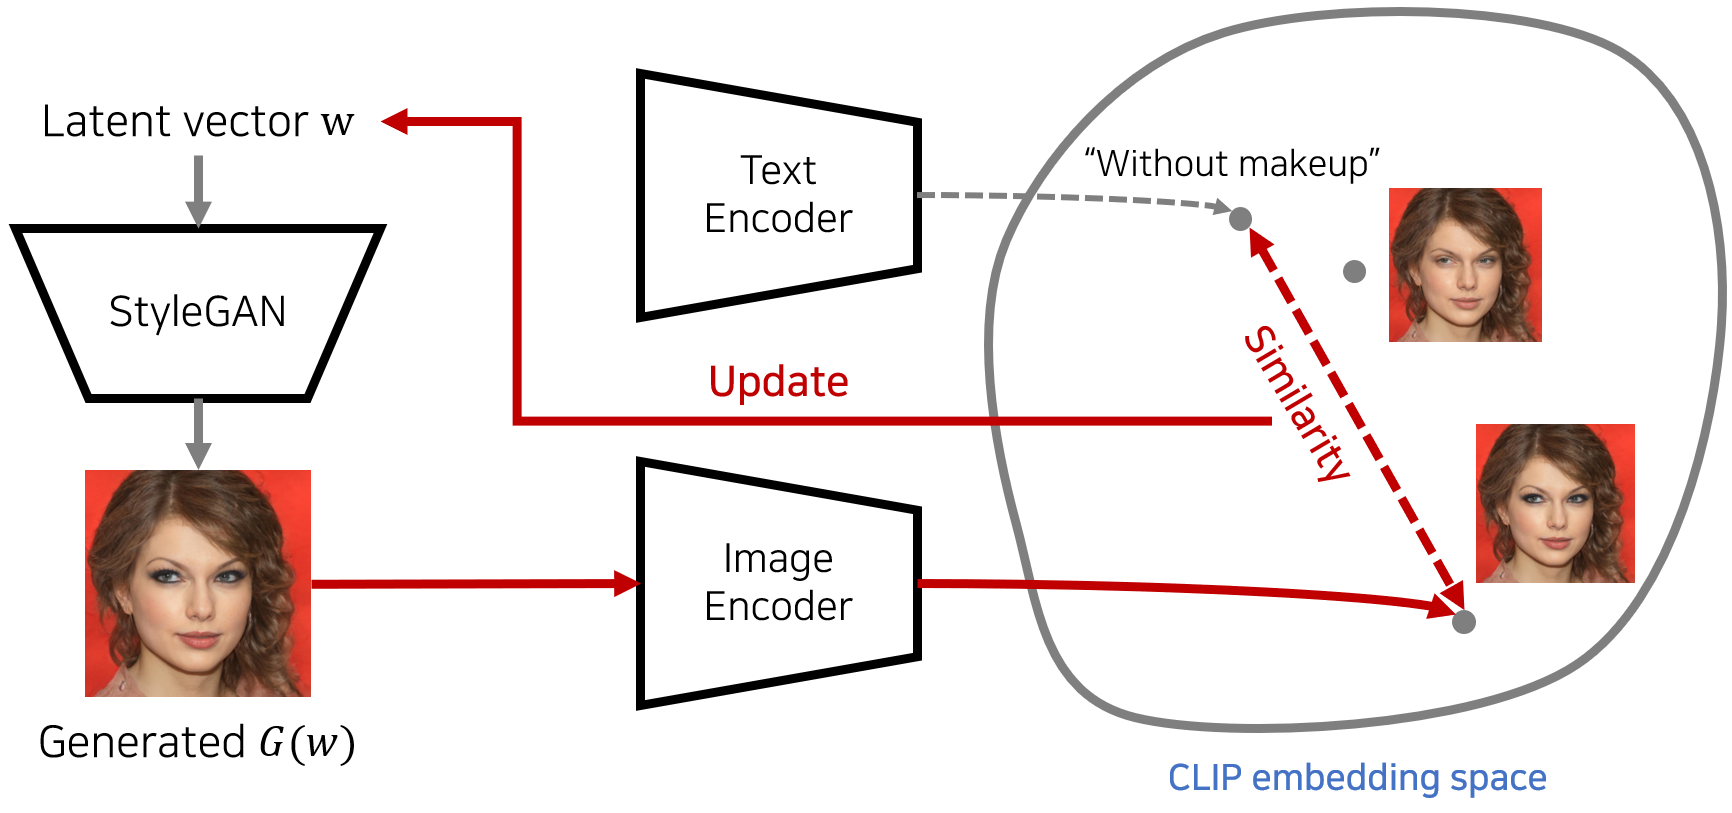

* Initialize a random latent vector using a mean latent vector.

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


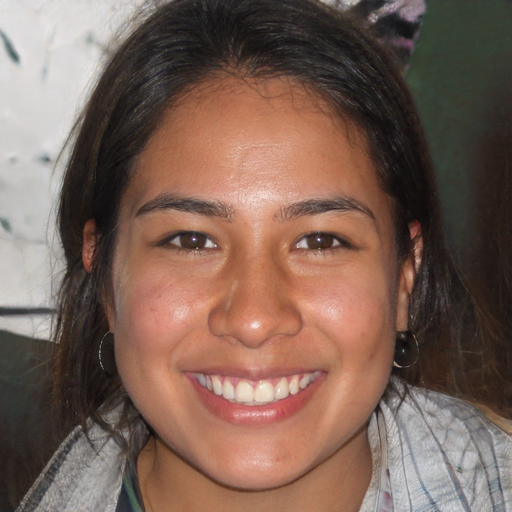

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


mean_latent = g_ema.mean_latent(4096)

latent_code_init_not_trunc = torch.randn(1, 512).cuda()
with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=0.7, truncation_latent=mean_latent)

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = image.size
image.resize((h // 2, w // 2))

* The optimization method updates the $w$ vector.
* In this source code, we use only $D_{CLIP}(G(w),t) + \lambda_{L2} ||w-w_s||_2$.

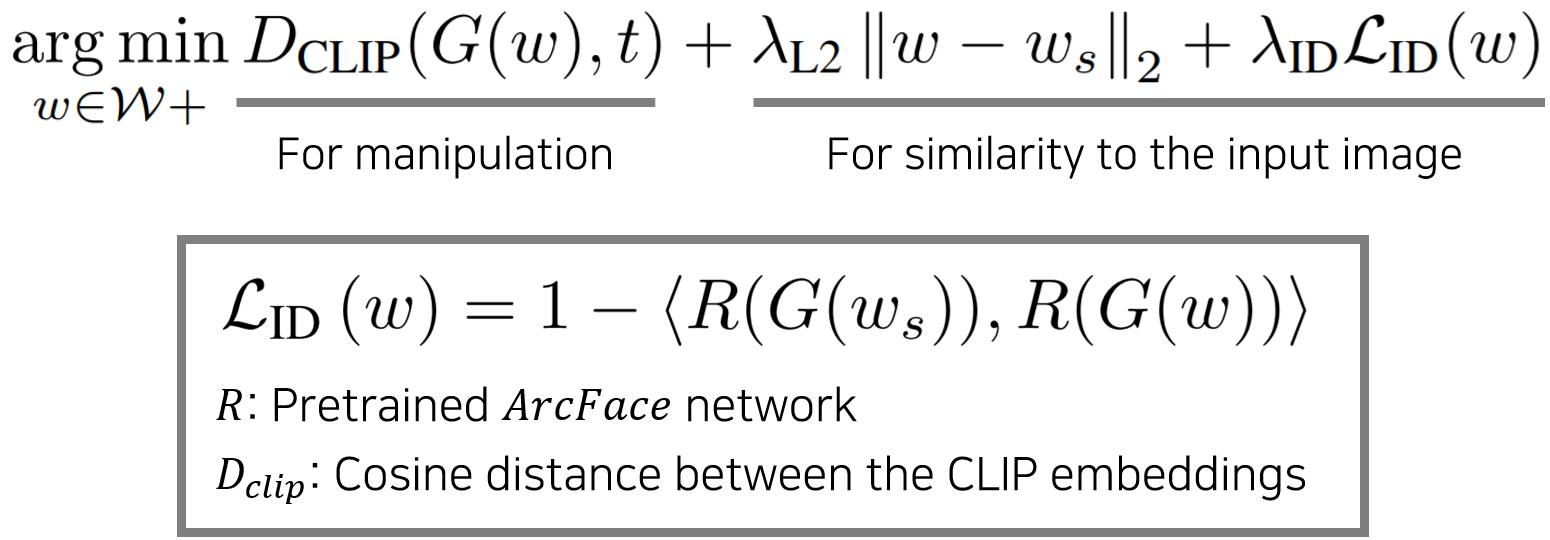

* Set parameters for a practice.

* Optimize a latent vector and get the result.

# **Clip Loss with L2 loss and cosine distance**

In [ ]:
import os
import math
import torchvision
from torch import optim
from argparse import Namespace

args = Namespace()
args.description = 'A very sad face'
args.lr_rampup = 0.05
args.lr = 0.01
args.step = 100
args.l1_lambda = 0.001
args.cos_lambda = 0.001 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir_modified = 'results_modified'

# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir_modified, exist_ok=True)


# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)
#optimizer = optim.Adagrad([latent], lr=args.lr)

# Define early stopping
loss_min = 9999
early_stopping_limit = 200
early_stopping_round=0

import statistics
for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    #lr = args.lr
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()


    

    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    cos_distance = (1 - abs(cos(latent_code_init,latent))).sum()
    loss = c_loss + args.l1_lambda * l2_loss  +  args.cos_lambda *  cos_distance
    #+ args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    loss_iter = loss.item()
    if loss_min > loss_iter:
      loss_min = loss_iter
      early_stopping_round=0
    else:
      early_stopping_round = early_stopping_round + 1
    if early_stopping_limit <=  early_stopping_round:
      print("optimizer converges")
      break

    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results_modified/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir_modified, "final_result_CLIP_L2_COS.jpg"), normalize=True, scale_each=True, range=(-1, 1))

lr: 0.0, loss: 0.7930


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


lr: 0.002, loss: 0.7930
lr: 0.004, loss: 0.7915
lr: 0.006, loss: 0.7856
lr: 0.008, loss: 0.7812
lr: 0.01, loss: 0.7764
lr: 0.01, loss: 0.7754
lr: 0.01, loss: 0.7749
lr: 0.01, loss: 0.7754
lr: 0.01, loss: 0.7749
lr: 0.01, loss: 0.7734
lr: 0.01, loss: 0.7720
lr: 0.01, loss: 0.7710
lr: 0.01, loss: 0.7695
lr: 0.01, loss: 0.7690
lr: 0.01, loss: 0.7681
lr: 0.01, loss: 0.7676
lr: 0.01, loss: 0.7671
lr: 0.01, loss: 0.7661
lr: 0.01, loss: 0.7656
lr: 0.01, loss: 0.7651
lr: 0.01, loss: 0.7646
lr: 0.01, loss: 0.7642
lr: 0.01, loss: 0.7637
lr: 0.01, loss: 0.7632
lr: 0.01, loss: 0.7632
lr: 0.01, loss: 0.7632
lr: 0.01, loss: 0.7627
lr: 0.01, loss: 0.7622
lr: 0.01, loss: 0.7622
lr: 0.01, loss: 0.7617
lr: 0.01, loss: 0.7612
lr: 0.01, loss: 0.7612
lr: 0.01, loss: 0.7603
lr: 0.01, loss: 0.7603
lr: 0.01, loss: 0.7603
lr: 0.01, loss: 0.7598
lr: 0.01, loss: 0.7598
lr: 0.01, loss: 0.7588
lr: 0.01, loss: 0.7588
lr: 0.01, loss: 0.7583
lr: 0.01, loss: 0.7583
lr: 0.01, loss: 0.7583
lr: 0.01, loss: 0.7568
lr: 0.0

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


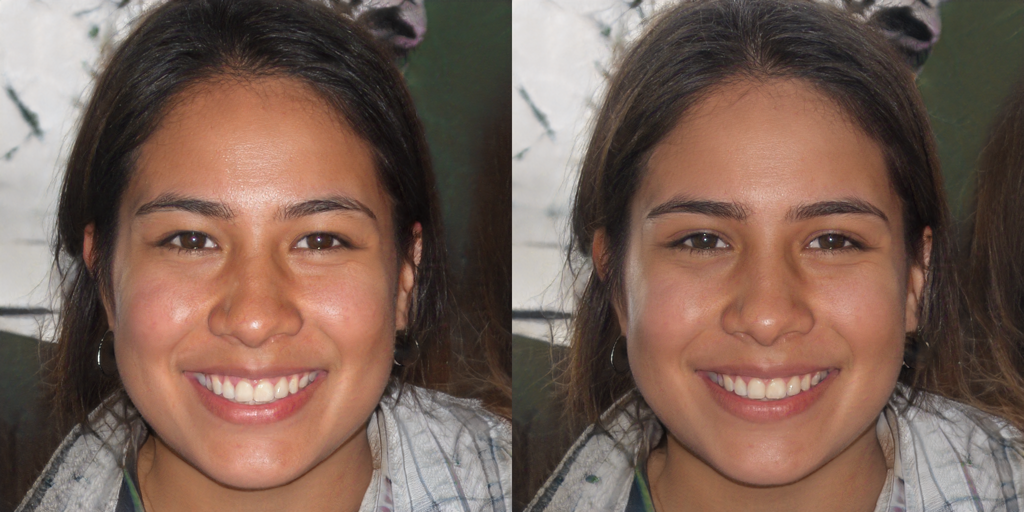

In [ ]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

# **Only Clip Loss**

In [ ]:
import statistics

args = Namespace()
args.description = 'A very sad face'
args.lr_rampup = 0.05
args.lr = 0.005
args.step = 100
args.l1_lambda = 0.01
args.cos_lambda = 0.01 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir_modified = 'results_modified'

text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir_modified, exist_ok=True)


# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)
#optimizer = optim.Adagrad([latent], lr=args.lr)

# Define early stopping
loss_min = 9999
early_stopping_limit = 200
early_stopping_round=0

for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    #lr = args.lr
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    loss = c_loss 

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    loss_iter = loss.item()
    if loss_min > loss_iter:
      loss_min = loss_iter
      early_stopping_round=0
    else:
      early_stopping_round = early_stopping_round + 1
    if early_stopping_limit <=  early_stopping_round:
      print("optimizer converges")
      break

    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results_modified/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir_modified, "final_result_CLIP.jpg"), normalize=True, scale_each=True, range=(-1, 1))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


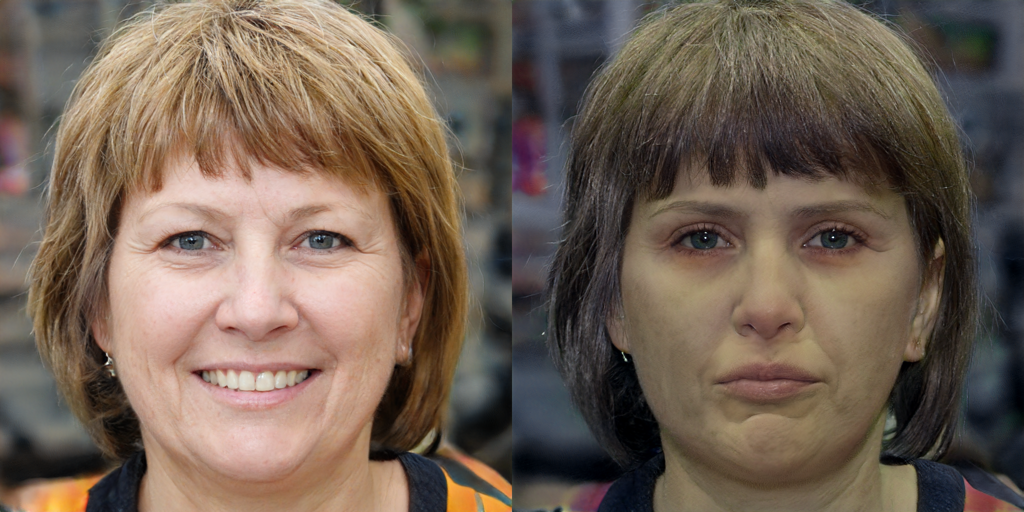

In [ ]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

# **Clip Loss and Minkowski Distance**

In [ ]:
import os
import math
import torchvision
from torch import optim
from argparse import Namespace

args = Namespace()
args.description = 'A really sad face'
args.lr_rampup = 0.05
args.lr = 0.001
args.step = 300
args.l1_lambda = 0.1 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir_modified = 'results_modified'

# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir_modified, exist_ok=True)


# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)
#optimizer = optim.Adagrad([latent], lr=args.lr)

# Define early stopping
loss_min = 9999
early_stopping_limit = 30
early_stopping_round=0

for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    #lr = args.lr
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)

    minkowski_distance = math.sqrt(((latent_code_init - latent)**4).sum())
    loss = c_loss + args.l1_lambda * minkowski_distance 
    #+ args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    loss_iter = loss.item()
    if loss_min > loss_iter:
      loss_min = loss_iter
      early_stopping_round=0
    else:
      early_stopping_round = early_stopping_round + 1
    if early_stopping_limit <=  early_stopping_round:
      print("optimizer converges")
      break

    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results_modified/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir_modified, "final_result_CLIP_MINKOWSKI.jpg"), normalize=True, scale_each=True, range=(-1, 1))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


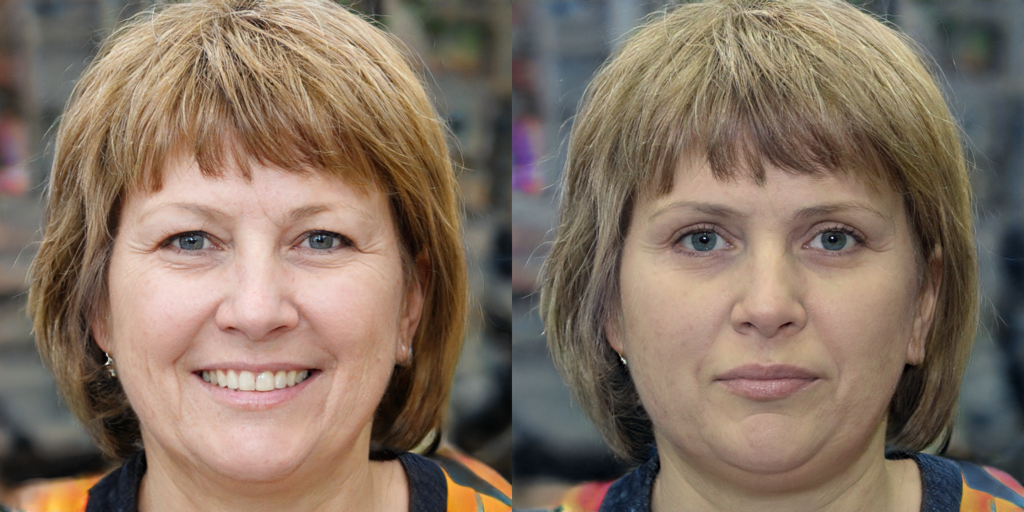

In [ ]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

# **Clip Loss with L2 Loss**

In [ ]:
import os
import math
import torchvision
from torch import optim
from argparse import Namespace

args = Namespace()
args.description = 'A very sad face'
args.lr_rampup = 0.05
args.lr = 0.05
args.step = 300
args.l2_lambda = 0.005 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir_original = 'results_original'


# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir_original, exist_ok=True)

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)

for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results_original/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir_original, "final_result_CLIP_L2.jpg"), normalize=True, scale_each=True, range=(-1, 1))

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


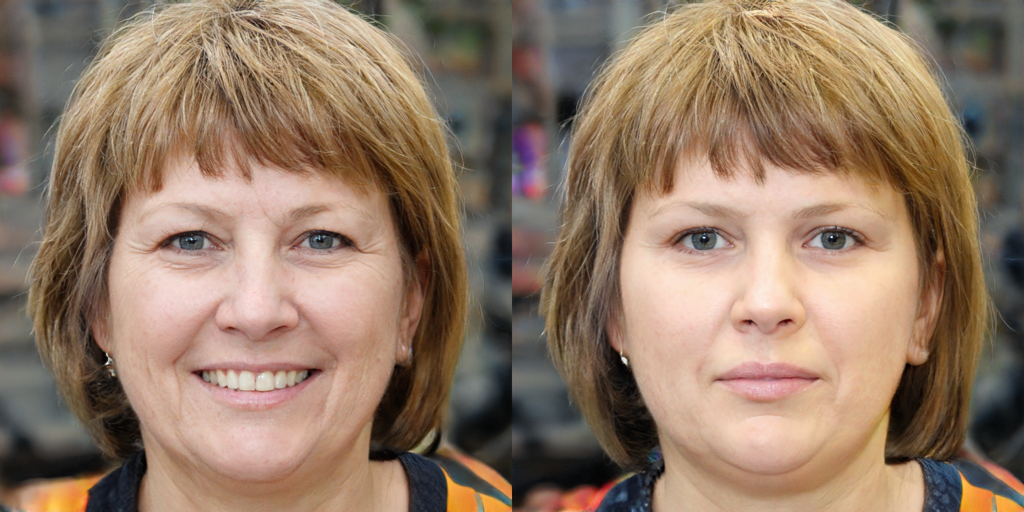

In [ ]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

* Generate an animation video and download the video.

In [ ]:
!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>